# stripers - All products
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 24, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 49 # stripers
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(3344, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3344 entries, 0 to 3343
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            3344 non-null   int64  
 1   dimCustomerMasterId     3344 non-null   int64  
 2   customerNumber          3344 non-null   object 
 3   year                    3344 non-null   int64  
 4   productGrouping         3344 non-null   object 
 5   totalSpent              3344 non-null   float64
 6   recentDate              3344 non-null   object 
 7   attendancePercent       3344 non-null   float64
 8   renewedBeforeDays       3344 non-null   int64  
 9   isBuyer                 3344 non-null   object 
 10  source_tenure           3344 non-null   int64  
 11  tenure                  3344 non-null   int64  
 12  distToVenue             0 non-null      object 
 13  totalGames              3344 non-null   int64  
 14  recency                 3344 non-null   

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = ["year",
            "isNextYear_Buyer",
            "productGrouping",
            "dimCustomerMasterId",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "is_Lockdown",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "NumberofGamesPerSeason"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (2150, 14)
Unseen Data For Predictions: (380, 14)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
     "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "is_Lockdown",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "NumberofGamesPerSeason"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7263,0.8011,0.6411,0.6808,0.6584,0.4308,0.4330,0.2730
lr,Logistic Regression,0.6952,0.7652,0.5288,0.6684,0.5869,0.3516,0.3595,0.3370


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6885,0.7477,0.5395,0.6508,0.5899,0.3423,0.3463
1,0.7322,0.8133,0.6053,0.7077,0.6525,0.4369,0.4404
2,0.7322,0.7945,0.6711,0.6800,0.6755,0.4476,0.4476
3,0.7322,0.8077,0.6579,0.6849,0.6711,0.4455,0.4457
4,0.7432,0.8214,0.6711,0.6986,0.6846,0.4681,0.4684
5,0.7322,0.7770,0.5467,0.7321,0.6260,0.4242,0.4352
6,0.7268,0.7775,0.6667,0.6667,0.6667,0.4352,0.4352
7,0.7253,0.8399,0.6933,0.6582,0.6753,0.4375,0.4380
8,0.7363,0.8386,0.6533,0.6901,0.6712,0.4513,0.4518
9,0.7143,0.7935,0.7067,0.6386,0.6709,0.4196,0.4213


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(814, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
2530,49,365781103,41434506,2021,Half Season,81.000000,2021-10-02,0.837838,11,TRUE,...,0,0,0.0,1,132,0,1,1,0.4758,0.5242
2531,49,365781124,7314973,2021,Voucher,14.000000,1970-01-01,0.000000,174,TRUE,...,0,0,0.0,1,132,0,1,0,0.9900,0.0100
2532,49,365781131,40418673,2021,Voucher,300.000000,2021-09-18,0.950000,108,TRUE,...,0,0,0.0,1,132,0,0,0,0.5999,0.4001
2533,49,365781137,30231837,2021,Voucher,2325.000000,2021-08-15,1.000000,8,TRUE,...,0,0,0.0,1,132,0,0,1,0.0272,0.9728
2534,49,365781142,25100357,2021,Partial Season,527.041667,1970-01-01,0.000000,86,TRUE,...,0,0,0.0,1,132,0,1,0,0.5337,0.4663


In [11]:
new_predictions["Label"].value_counts()

1    424
0    390
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(0.8, 1.0]       249
(-0.001, 0.2]    196
(0.2, 0.4]       128
(0.6, 0.8]       123
(0.4, 0.6]       118
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

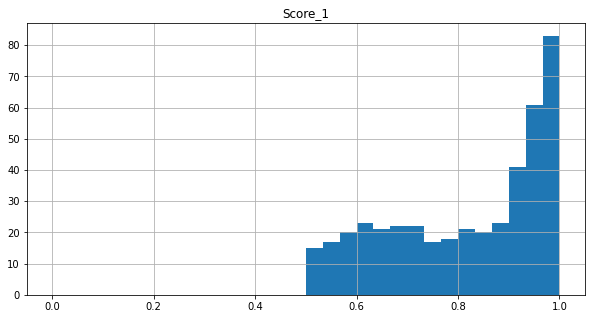

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

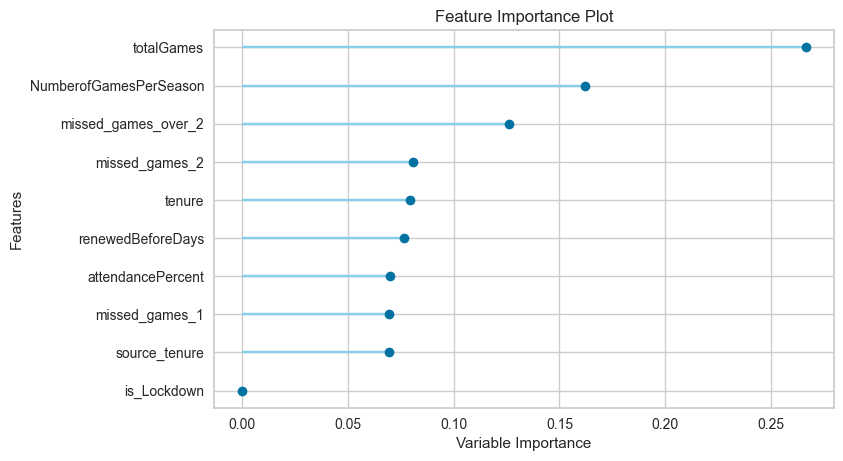

In [14]:
plot_model(best_model, plot='feature')

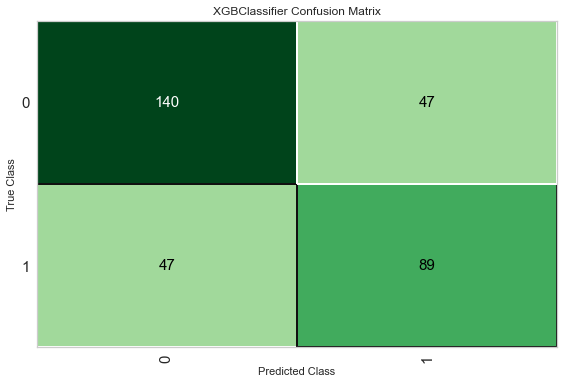

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?